In [1]:
import os, sys, time, math, shutil
from natsort import natsorted #, ns

import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma
# from PIL import Image
import glob
# import re
from tifffile import imwrite
import json 

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
# from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

# from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
# from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen



import utils
from utils import average_images, flatField, getReference, displayResult, fitnessMSE, fitnessMAE, fitnessSSIM, fitnessZNCC, getXrayImage
from utils import bbox, plot_directory, applyTransformation



Tue Nov 21 13:24:00 2023 (WW) Spekpy is not installed, try Xpecgen instead.
Tue Nov 21 13:24:00 2023 (WW) Xpecgen is not installed either.


spekpy is not install, you won't be able to load a beam spectrum using spekpy
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.8 (2023-11-20T14:28:40) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.8 (2023-11-20T14:28:40) [Compiler: GNU g++] on Linux


In [2]:
utils.use_padding = False
utils.pad_width = 50
angular_step_in_deg = 3.6

In [3]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
#data_path = "4thOCtober_image/"
#data_path = "4thCotober_imageAngle/"
data_path = "25OctoberData/"
#data_path = "15NovemberData/"

In [4]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

json_file = current_folder + "/simulation2.json"

/home/fpvidal/PROGRAMMING/GitHub/MyProjects


In [5]:
# dirs = [
#     current_folder + "/" + data_path + "/plot1",
#     current_folder + "/" + data_path + "/plot2"
# ]

# for directory in dirs:
#     if os.path.isdir(directory):
#         shutil.rmtree(directory)

#     if not os.path.exists(directory):
#         os.mkdir(directory)

In [6]:
#path for my recently acquired images stored in PhD file



dark_field_paths = glob.glob(data_path + '/darkfd/darkfd_*.tiff')
dark_field_paths = natsorted(dark_field_paths, key=lambda y: y.lower())

white_field_paths = glob.glob(data_path + '/whitefd/whitefd_*.tiff')
white_field_paths = natsorted(white_field_paths, key=lambda y: y.lower())

raw_image_paths = glob.glob(data_path + '/raw_images/raw_image_*.tiff')
raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

if len(raw_image_paths) == 0:
    raw_image_paths = glob.glob(data_path + '/rawimages/raw_images_*.jpg')
    raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

In [7]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)

In [8]:
I_raw = []
angles_in_deg = []
for i, fname in enumerate(raw_image_paths):

    angle = angular_step_in_deg * i

    if angle < 360.000001:
        angles_in_deg.append(angular_step_in_deg * i)
        I_raw.append(cv2.imread(fname, 
                               cv2.IMREAD_GRAYSCALE))
    
        if utils.use_padding:
            median_value = np.median(I_raw[-1])
            I_raw[-1] = np.pad(I_raw[-1], (pad_width, pad_width), 'constant', constant_values=(median_value, median_value))

I_raw = np.array(I_raw, dtype=np.single)
# I_raw = average_images(raw_image_paths)

# for image in I_raw:
#     image /= np.mean(image[:,0:200])

# I_white /= np.mean(I_white[:,0:200])
# I_dark /= np.mean(I_dark[:,0:200])

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# Clamp pixel values
I_flat1[I_flat1<0] = 0
I_flat2[I_flat2<0] = 0

I_flat1[I_flat1>1] = 1
I_flat2[I_flat2>1] = 1

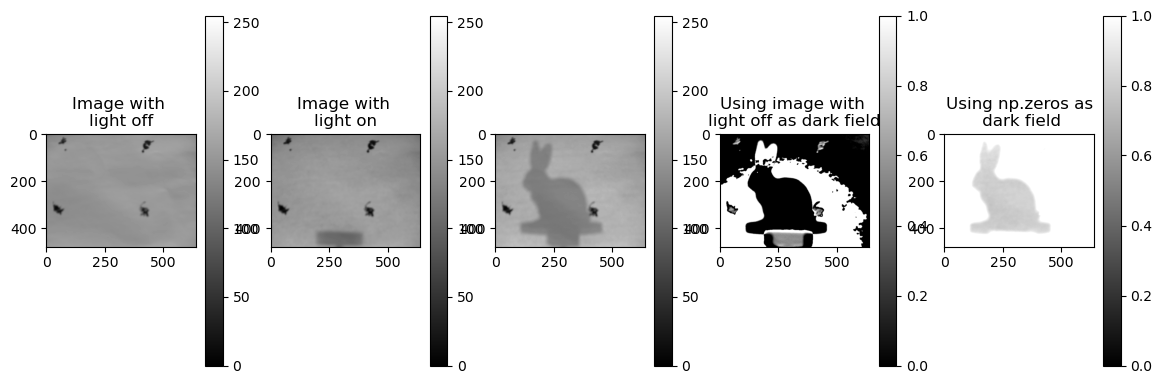

In [9]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()


In [10]:
I_flat = I_flat2

In [11]:
if not os.path.exists(data_path + "/flat_images"):
    os.mkdir(data_path + "/flat_images")

for i, img in enumerate(I_flat):
    imwrite(data_path + "/flat_images/projection_" + str(i).zfill(4) + ".tif", img)

In [12]:
#sod = 43
#sod =47
#sod = 48
#sdd = 61
#for rabbit
#sod=41
#sdd=51
sod=104
sdd=130
#sod = 25
#sdd=61

In [13]:
Ti90Al10 = 5.68
x_src = 0
y_src = -sod
z_src = 0

x_det = 0
y_det = (sdd - sod)
z_det = 0

x_rot = 0
y_rot = 5
z_rot = 0

x_obj = 0
y_obj = 5
z_obj = 0

alpha_x =  90 
alpha_y = -90
alpha_z =   0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_rot,
    y_rot,
    z_rot,
    
    x_obj,
    y_obj,
    z_obj,
    
    alpha_x,
    alpha_y,
]

In [14]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR(json_file, "OPENGL", 3, 2)

Create an OpenGL context: 800x600


Tue Nov 21 13:24:06 2023 ---- Create window (ID: -1)
Tue Nov 21 13:24:06 2023 ---- Initialise GLFW
Tue Nov 21 13:24:06 2023 ---- Create an OpenGL window with a 3.2 context.
Tue Nov 21 13:24:06 2023 ---- Make the window's context current
Tue Nov 21 13:24:06 2023 ---- Initialise GLEW
Tue Nov 21 13:24:06 2023 ---- OpenGL vendor: NVIDIA Corporation
Tue Nov 21 13:24:06 2023 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Tue Nov 21 13:24:06 2023 ---- OpenGL version: 3.2.0 NVIDIA 535.104.05
Tue Nov 21 13:24:06 2023 ---- Use OpenGL 4.5.
Tue Nov 21 13:24:06 2023 ---- Initialise the X-ray renderer if needed and if possible


In [15]:
# Load our source properties
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [16]:
# Load our detector
json2gvxr.initDetector()
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

if utils.use_padding:
    number_of_pixels = gvxr.getDetectorNumberOfPixels();
    gvxr.setDetectorNumberOfPixels(number_of_pixels[0] + 2 * pad_width, number_of_pixels[1] + 2 * pad_width);

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']


Tue Nov 21 13:24:06 2023 ---- Initialise the renderer


In [17]:
# Load our samples
json2gvxr.initSamples(json_file, verbose=0)

gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

Tue Nov 21 13:24:06 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/MyProjects/Rabbit.stl	nb_faces:	75710	nb_vertices:	227130	bounding_box (in cm):	(-1.14473, -1.27, -1.20062)	(1.14473, 1.27, 1.20062)
Tue Nov 21 13:24:06 2023 (WW) PolygonMesh cuboid not found in g_p_polygon_mesh_set.


In [18]:
gvxr.computeXRayImage();
gvxr.displayScene()
gvxr.setZoom(190)
gvxr.setSceneRotationMatrix([0.6925417184829712, 0.010556249879300594, -0.7213009595870972, 0.0, -0.7204560041427612, 0.060654886066913605, -0.6908417344093323, 0.0, 0.036457497626543045, 0.998101532459259, 0.04961010813713074, 0.0, 0.0, 0.0, 0.0, 1.0])

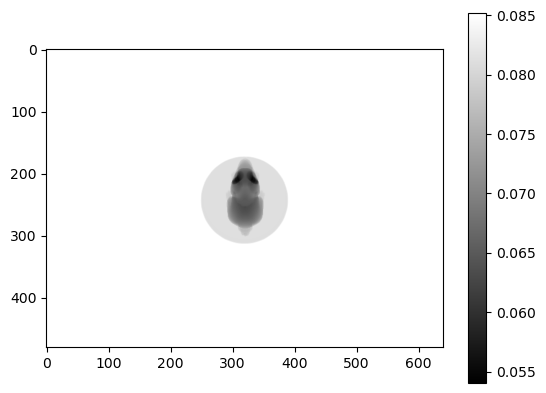

In [19]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [20]:
utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 1)

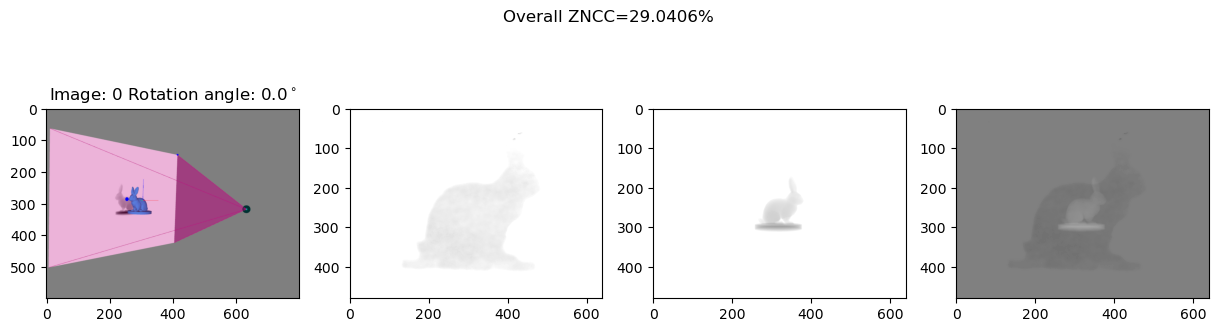

In [21]:
displayResult(x_default)

In [22]:
utils.figsize = (15, 12)
utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 4)

In [23]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-4);
opts['tolx'] = 1e-4;
# opts['bounds'] = [np.hstack((12*[-1000], 3*[-180])), np.hstack((12*[1000], 3*[180]))];
opts['bounds'] = [[-200, -1000, -200, # source position
                   -200,    0, -200,  # detector position
                   -200, -200, -200,  # rotation axis position
                   -200, -200, -200,  # object position on turntable
                   -180, -180], # object orientation
                  
                  [ 200,    0, 200,   # source position
                    200, 1000, 200,   # detector position
                    200,  200, 200,   # rotation axis position
                    200,  200, 200,   # object position on turntable
                    180,  180]]; # object orientation

x_fname       = current_folder + "/" + data_path + "/x_best1.dat"
fitness_fname = current_folder + "/" + data_path + "/fitness_set1.npz"
utils.plot_directory = current_folder + "/" + data_path + "/plot1"

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    

    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 5, opts);
    es.optimize(fitnessMSE);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best1 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 14 (seed=662106, Tue Nov 21 13:24:07 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 4.427724983543158e-03 1.0e+00 4.91e+00  5e+00  5e+00 0:07.9
    2     22 4.472795408219099e-03 1.2e+00 5.09e+00  5e+00  5e+00 0:08.8
    3     33 4.392374306917191e-03 1.2e+00 4.91e+00  5e+00  5e+00 0:11.5
    4     44 4.343780688941479e-03 1.3e+00 4.63e+00  4e+00  5e+00 0:15.9
    6     66 4.240490030497313e-03 1.3e+00 4.22e+00  4e+00  4e+00 0:21.1
    8     88 4.130977205932140e-03 1.3e+00 4.17e+00  4e+00  4e+00 0:26.3
   12    132 3.932306077331305e-03 1.6e+00 4.25e+00  4e+00  5e+00 0:35.1
   17    187 3.823712700977921e-03 1.9e+00 4.27e+00  4e+00  5e+00 0:42.8
   21    231 3.533264854922891e-03 2.1e+00 4.27e+00  3e+00  5e+00 0:51.2
   30    330 3.059080103412271e-03 2.8e+00 4.30e+00  3e+00  5e+00 1:02.4
   35    385 3.036883892491460e-03 2.9e+00 3.78e+00  3e+00  5e+00 1:13.2
   42    462 2.880241489037871e-0

Text(0, 0.5, 'Fitness value (MSE)')

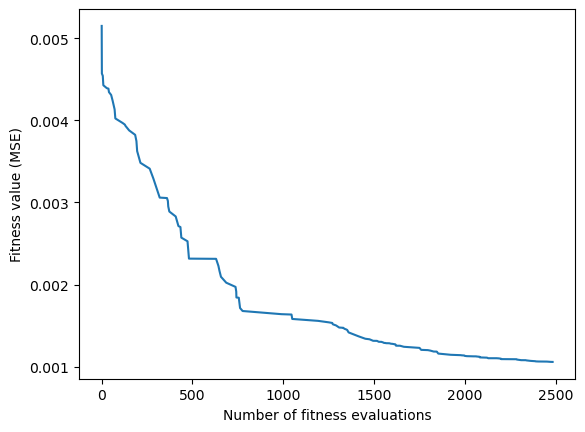

In [24]:
plt.plot(utils.fitness_set[:,0], utils.fitness_set[:,1])
plt.xlabel("Number of fitness evaluations")
plt.ylabel("Fitness value (MSE)")

In [25]:
print(x_best1)

[ -4.48367426 -81.05490616  -8.35565879 -53.65660009 121.25191335
 -25.95990393 -17.16006066 -21.60189542  19.76707635 -18.05098508
 -24.53775744 -11.80886636  92.69699787 -51.89968154]


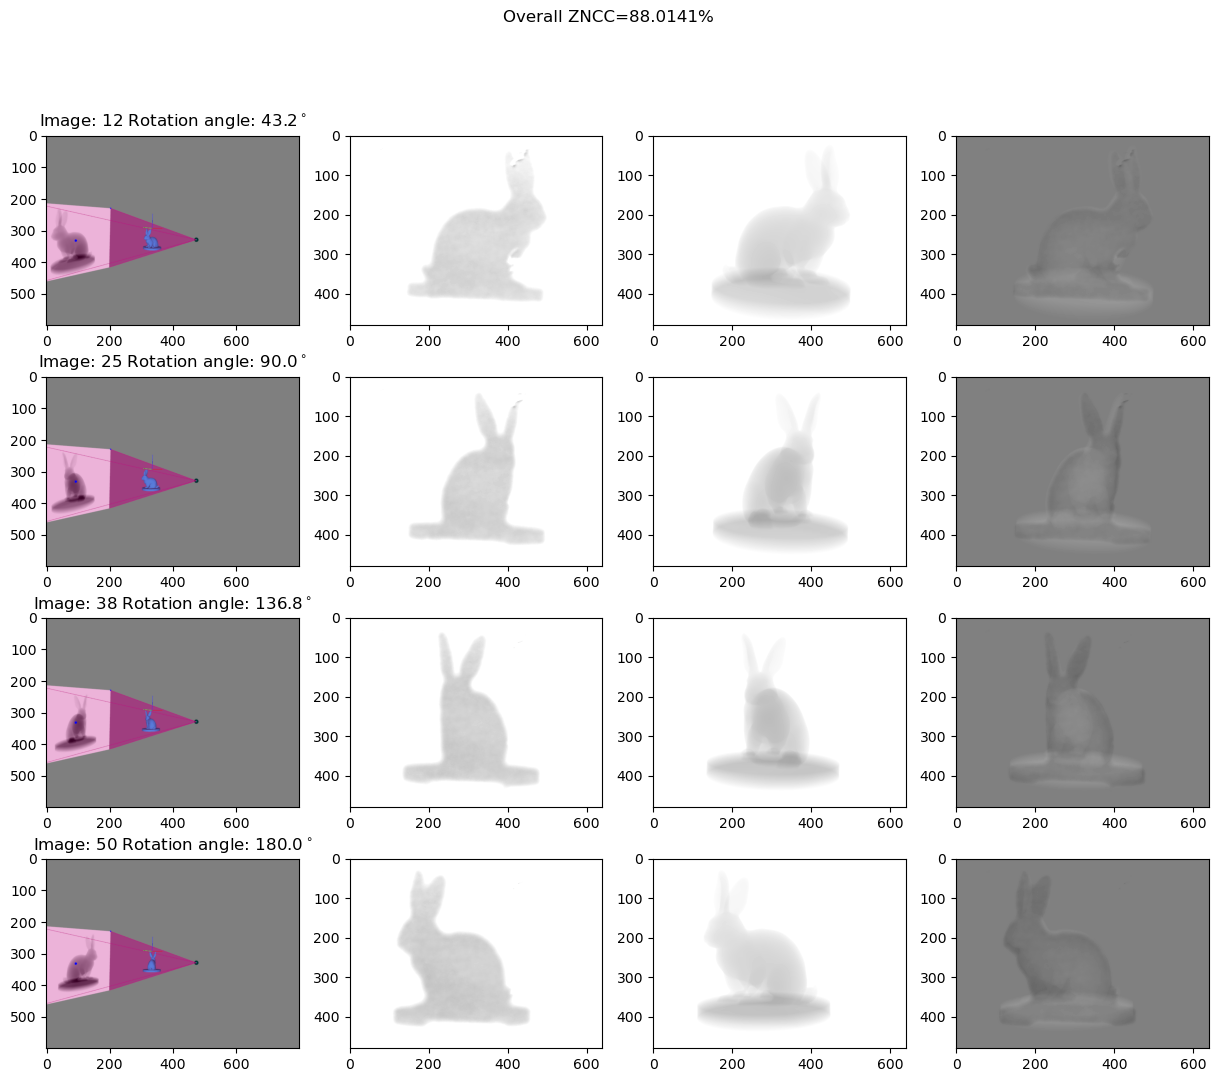

In [26]:
displayResult(x_best1, figsize=(15, 12))

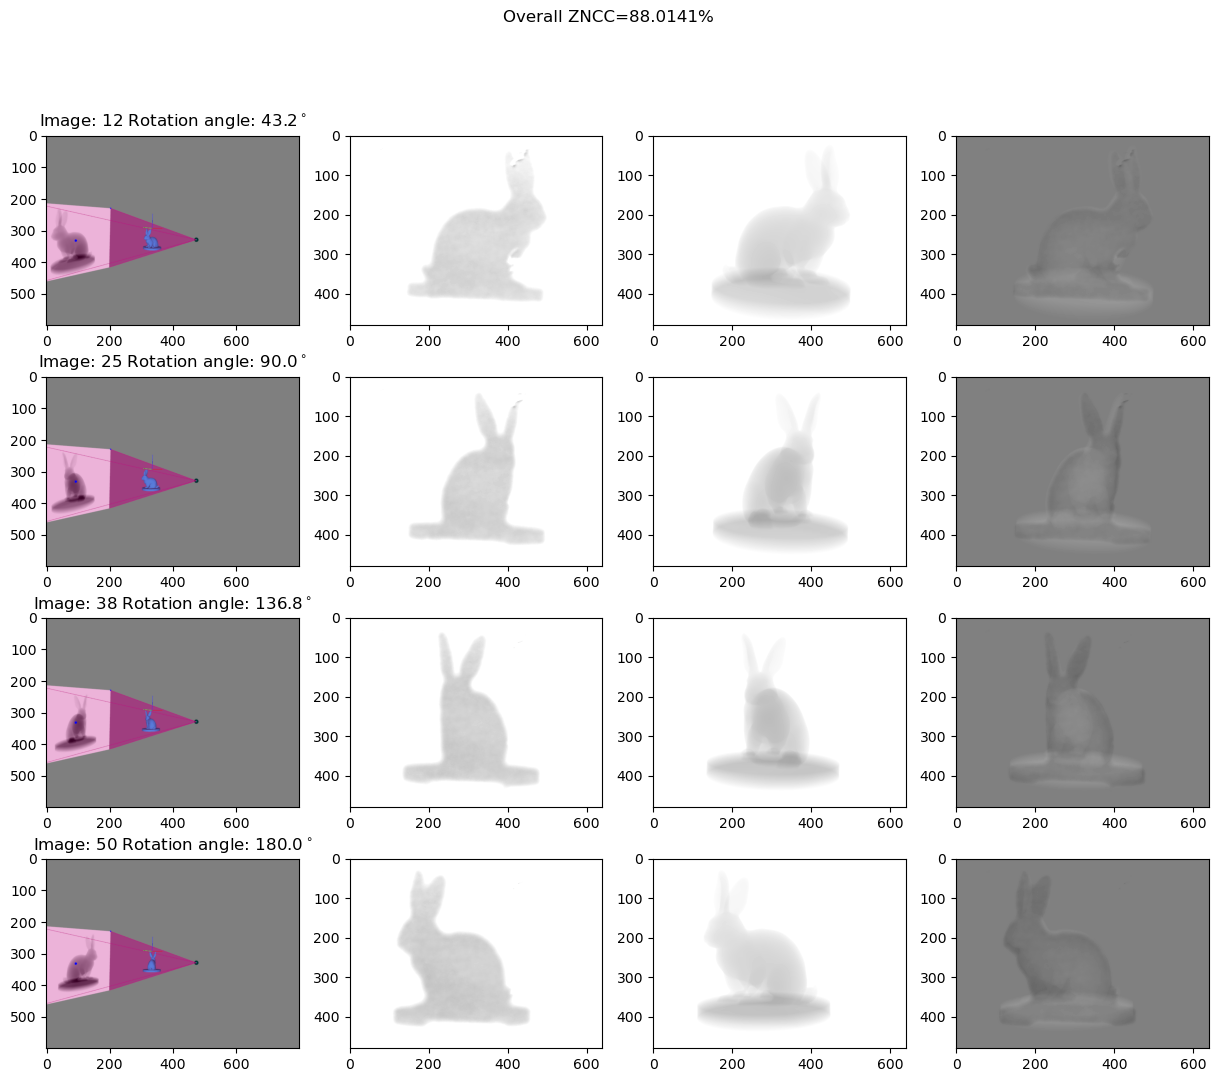

In [27]:
# utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 7)
# displayResult(x_best1, figsize=(15, 12))

In [28]:
opts.set('tolfun', 1e-4);
opts['tolx'] = 1e-4;

x_current = x_best1
opts['bounds'] = [[x_current[ 0] - 20, x_current[ 1] - 20, x_current[ 2] - 20,  # source position
                   x_current[ 3] - 20, x_current[ 4] - 20, x_current[ 5] - 20,  # detector position
                   x_current[ 6] - 20, x_current[ 7] - 20, x_current[ 8] - 20,  # rotation axis position
                   x_current[ 9] - 20, x_current[10] - 20, x_current[11] - 20,  # object position on turntable
                   x_current[12] - 30, x_current[13] - 30],                     # object orientation
                  
                  [x_current[ 0] + 20, x_current[ 1] + 20, x_current[ 2] + 20,  # source position
                   x_current[ 3] + 20, x_current[ 4] + 20, x_current[ 5] + 20,  # detector position
                   x_current[ 6] + 20, x_current[ 7] + 20, x_current[ 8] + 20,  # rotation axis position
                   x_current[ 9] + 20, x_current[10] + 20, x_current[11] + 20,  # object position on turntable
                   x_current[12] + 30, x_current[13] + 30]]                     # object orientation

x_fname       = current_folder + "/" + data_path + "/x_best2.dat"
fitness_fname = current_folder + "/" + data_path + "/fitness_set2.npz"
utils.plot_directory = current_folder + "/" + data_path + "/plot2"

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    
    
    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1
        
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best1, 0.5, opts);
    es.optimize(fitnessZNCC);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best2 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 14 (seed=752745, Tue Nov 21 13:30:49 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.142382449222275e+00 1.0e+00 4.77e-01  5e-01  5e-01 0:06.3
    2     22 1.141840535858449e+00 1.2e+00 4.47e-01  4e-01  5e-01 0:08.7
    3     33 1.137229816498059e+00 1.2e+00 4.08e-01  4e-01  4e-01 0:11.1
    5     55 1.135630295467203e+00 1.3e+00 4.04e-01  4e-01  4e-01 0:14.5
    8     88 1.135543593293685e+00 1.5e+00 4.50e-01  4e-01  5e-01 0:18.9
   12    132 1.134336443359802e+00 1.7e+00 4.01e-01  3e-01  4e-01 0:24.2
   18    198 1.134194959769284e+00 1.9e+00 3.26e-01  3e-01  4e-01 0:31.3
   25    275 1.134449502230091e+00 2.3e+00 2.72e-01  2e-01  3e-01 0:38.6
   35    385 1.134340201399757e+00 2.8e+00 1.79e-01  1e-01  2e-01 0:46.9
   41    451 1.133317706535492e+00 3.1e+00 1.56e-01  1e-01  2e-01 0:57.0
   43    473 1.132472309056131e+00 3.2e+00 1.55e-01  1e-01  2e-01 1:08.3
   53    583 1.132370420276331e+0

Text(0, 0.5, 'ZNCC (in %)')

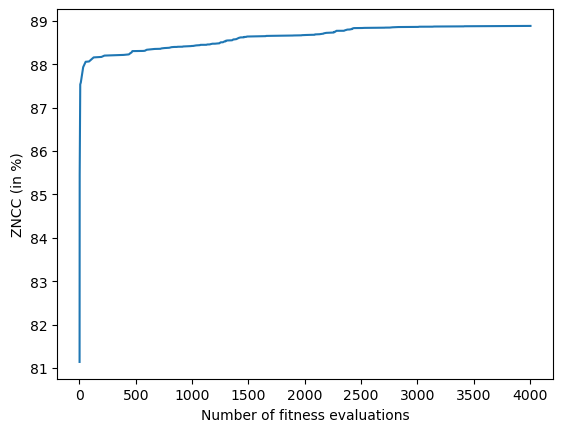

In [29]:
plt.plot(utils.fitness_set[:,0], 100*utils.fitness_set[:,1])
plt.xlabel("Number of fitness evaluations")
plt.ylabel("ZNCC (in %)")

In [30]:
print(x_best2)

[  15.48341516 -100.98875725   -6.01621808  -73.12152758  141.24848658
  -23.53249167   -8.13567951  -31.9333843    11.51839723   -8.85568808
  -34.77016511   -9.13990795   92.66951283  -43.54791113]


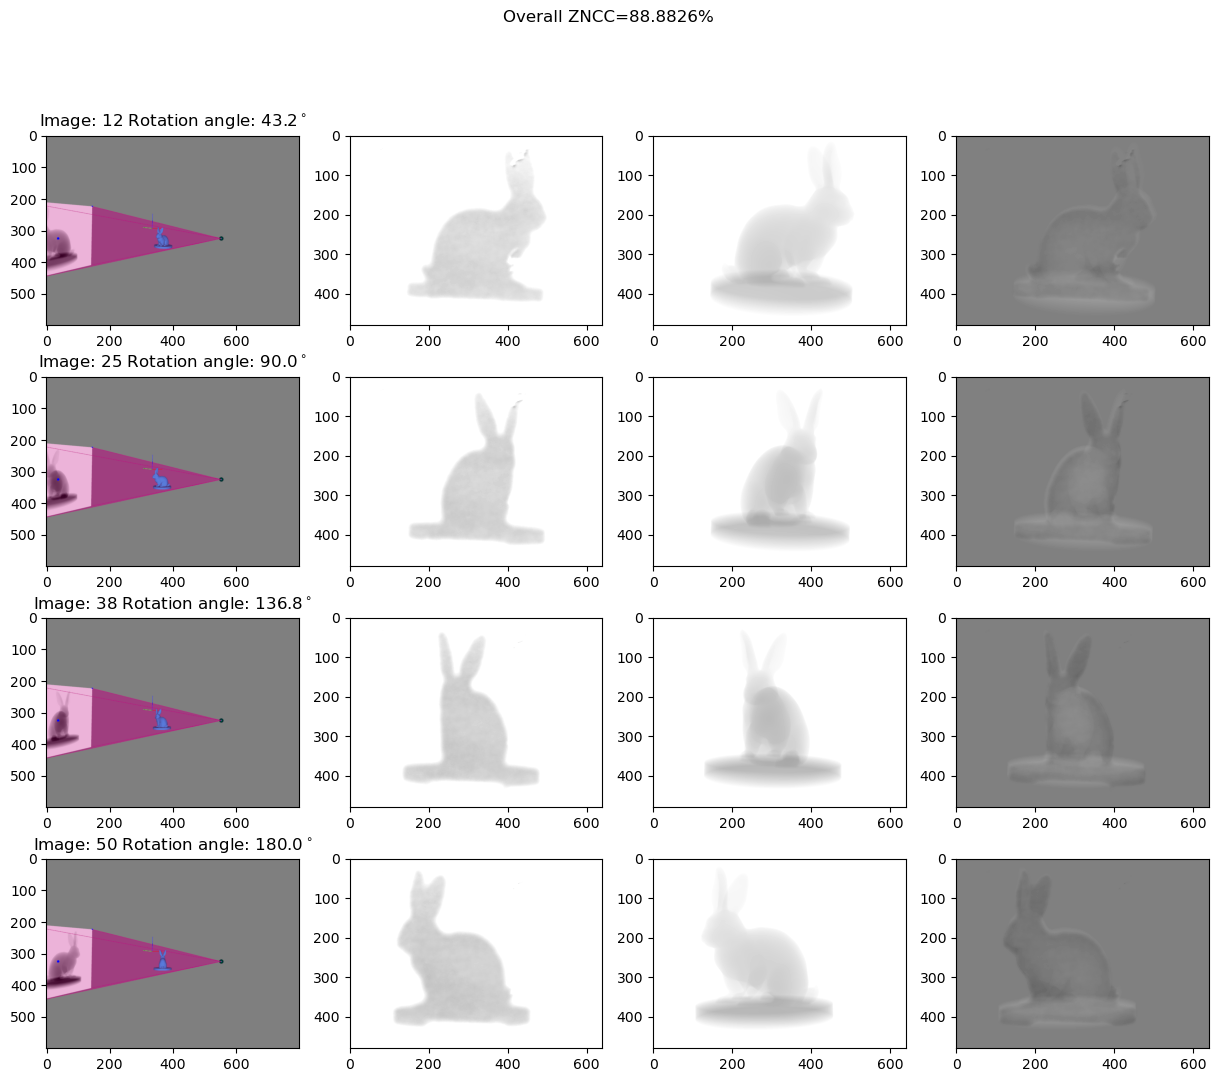

In [31]:
displayResult(x_best2, figsize=(15, 12))

In [32]:
def getCentreOfRotationPosition(x):
   
    x_rot_axis_pos = x[6]
    y_rot_axis_pos = x[7]
    z_rot_axis_pos = x[8]

    return np.array([x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos])

    # Global coordinates
    return np.array([(utils.bbox[0] + utils.bbox[3]) / 2,
                    (utils.bbox[1] + utils.bbox[4]) / 2,
                    (utils.bbox[2] + utils.bbox[5]) / 2])

def getSourcePosition(x):
    return np.array([x[0], x[1], x[2]])
    
def getDetectorPosition(x):
    return np.array([x[3], x[4], x[5]])
    
def getRotationAxisPosition(x):
    x_rot_axis_pos = x[6]
    y_rot_axis_pos = x[7]
    z_rot_axis_pos = x[8]

def printX(x):



    x_obj = x[9]
    y_obj = x[10]
    z_obj = x[11]
    
    alpha_x = x[12]
    alpha_y = x[13]
    # alpha_z = x[14]

    print("Source position:", getSourcePosition(x), "mm")
    print("Detector position:", getDetectorPosition(x), "mm")
    print("Source-Detector Distance (SDD):", math.sqrt(math.pow(x_src - x_det, 2) + math.pow(y_src - y_det, 2) + math.pow(z_src - z_det, 2)), "mm")
    print("Object position:", x_obj, y_obj, z_obj, "mm")
    print("Centre of rotation position:", getCentreOfRotationPosition(x), "mm")
    
printX(x_best2)

Source position: [  15.48341516 -100.98875725   -6.01621808] mm
Detector position: [-73.12152758 141.24848658 -23.53249167] mm
Source-Detector Distance (SDD): 130.0 mm
Object position: -8.85568807964079 -34.770165112380425 -9.139907945369199 mm
Centre of rotation position: [ -8.13567951 -31.9333843   11.51839723] mm


In [33]:
def saveJSON(x, fname, image_path):

    x_rot_axis_pos = x[6]
    y_rot_axis_pos = x[7]
    z_rot_axis_pos = x[8]

    x_obj = x[9]
    y_obj = x[10]
    z_obj = x[11]

    alpha_x = x[12]
    alpha_y = x[13]
    # alpha_z = x[14]

    dictionary = {}

    dictionary["WindowSize"] = [800, 600]
    dictionary["Detector"] = {}
    dictionary["Detector"]["Position"] = [
        getDetectorPosition(x)[0],
        getDetectorPosition(x)[1],
        getDetectorPosition(x)[2],
        "mm"]
    dictionary["Detector"]["UpVector"] = gvxr.getDetectorUpVector()
    dictionary["Detector"]["NumberOfPixels"] = gvxr.getDetectorNumberOfPixels()
    dictionary["Detector"]["Size"] = [
        gvxr.getDetectorSize("mm")[0],
        gvxr.getDetectorSize("mm")[1],
        "mm"]

    dictionary["Source"] = {}
    dictionary["Source"]["Position"] = [
        getSourcePosition(x)[0],
        getSourcePosition(x)[1],
        getSourcePosition(x)[2],
        "mm"]
    dictionary["Source"]["Shape"] = "PointSource"
    dictionary["Source"]["Beam"] = []
    
    for energy, count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):
        dictionary["Source"]["Beam"].append({})
        dictionary["Source"]["Beam"][-1]["Energy"] = energy
        dictionary["Source"]["Beam"][-1]["Unit"] = "keV"
        dictionary["Source"]["Beam"][-1]["PhotonCount"] = count

    dictionary["Samples"] = []
    
    for mesh in json2gvxr.params["Samples"]:
        dictionary["Samples"].append({})
        dictionary["Samples"][-1]["Label"] = mesh["Label"]
        dictionary["Samples"][-1]["Path"] = "../" + mesh["Path"]
        dictionary["Samples"][-1]["Unit"] = mesh["Unit"]
        dictionary["Samples"][-1]["Material"] = mesh["Material"]
        dictionary["Samples"][-1]["Density"] = mesh["Density"]
    
        dictionary["Samples"][-1]["Transform"] = []
        dictionary["Samples"][-1]["Transform"].append(["Translation", x_obj, y_obj, z_obj, "mm"])
        dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_x, 1, 0, 0])
        dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_y, 0, 1, 0])
        dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_z, 0, 0, 1])
    
    dictionary["Scan"] = {}
    rot_centre = getCentreOfRotationPosition(x)
    # rot_centre = [x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos] # local
    dictionary["Scan"]["CenterOfRotation"] = [
        x_rot_axis_pos,
        y_rot_axis_pos,
        z_rot_axis_pos,
        "mm"]
    
    dictionary["Scan"]["FinalAngle"] = (I_flat.shape[0] - 1) * 3.6
    dictionary["Scan"]["IncludeFinalAngle"] = True
    dictionary["Scan"]["NumberOfProjections"] = I_flat.shape[0]
    dictionary["Scan"]["GifPath"] = "preview.gif"
    dictionary["Scan"]["OutFolder"] = image_path
    dictionary["Scan"]["Flat-Field Correction"] = True
    
    
    # Convert and write JSON object to file
    with open(fname, "w") as outfile: 
        json.dump(dictionary, outfile, indent = 4)


visible_light_CT_json_file = current_folder + "/" + data_path + "/visible_light.json"
simulated_CT_json_file = current_folder + "/" + data_path + "/simulation.json"

saveJSON(x_best2, visible_light_CT_json_file, "flat_images/")
saveJSON(x_best2, simulated_CT_json_file,     "simulation/")

In [34]:
applyTransformation(x_best2)

x = x_best2
print("rot:", x[6], x[7], x[8])
print("obj:", x[9], x[10], x[11])

label = "Rabbit"

identity_matrix = [
    1, 0, 0, 0,
    0, 1, 0, 0,
    0, 0, 1, 0,
    0, 0, 0, 1
]

gvxr.setLocalTransformationMatrix("root", identity_matrix)

# label = "root"
print(gvxr.getNodeLocalTransformationMatrix(label)[3])
print(gvxr.getNodeWorldTransformationMatrix(label)[3])

print(gvxr.getNodeLocalTransformationMatrix("root")[3])

rot: -8.135679514477234 -31.933384303863242 11.518397225631954
obj: -8.85568807964079 -34.770165112380425 -9.139907945369199
(-8.855688095092773, -34.770164489746094, -9.139907836914062, 1.0)
(-8.855688095092773, -34.770164489746094, -9.139907836914062, 1.0)
(0.0, 0.0, 0.0, 1.0)


In [35]:
old_bbox = gvxr.getNodeAndChildrenBoundingBox("Rabbit", "mm") # Not necessary aligned on world axes
gvxr.applyCurrentLocalTransformation("Rabbit")
new_bbox = gvxr.getNodeAndChildrenBoundingBox("Rabbit", "mm") # Aligned on world axes

In [36]:
for i, j in zip(new_bbox, old_bbox):
    print(i - j)

-11.063056945800781
6.590049743652344
-1.2868709564208984
11.833319664001465
-4.706819534301758
0.7221918106079102


In [37]:
(-26.576030731201172,
 22.208110809326172,
 9.765658378601074,
 -4.4660139083862305,
 47.86103820800781,
 34.24010467529297)

(-26.576030731201172,
 22.208110809326172,
 9.765658378601074,
 -4.4660139083862305,
 47.86103820800781,
 34.24010467529297)

In [38]:
gvxr.renderLoop()